Pruebas en el modelo v6

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import _init_paths

import os

import torch
import torch.utils.data
from opts import opts
from models.model import create_model, load_model, save_model
from models.data_parallel import DataParallel
from logger import Logger
from datasets.dataset_factory import get_dataset
from trains.train_factory import train_factory
import cv2
import sys
%matplotlib inline
import matplotlib.pyplot as plt
from detectors.detector_factory import detector_factory

image_ext = ['jpg', 'jpeg', 'png', 'webp']
video_ext = ['mp4', 'mov', 'avi', 'mkv']
time_stats = ['tot', 'load', 'pre', 'net', 'dec', 'post', 'merge']

In [3]:
sys.argv = ['-f', 'ctdetv2', '--demo', '../images/yolo/', '--arch','dlav6_34',  '--load_model' ,'../exp/ctdetv2/coco_dlav6/model_best_35.pth'] #cmd = 'ctdet --exp_id coco_dla --batch_size 4 --lr 1.25e-4  --gpus 0 --num_workers 0'
opt = opts().parse()
print(opt.task)

Fix size testing.
training chunk_sizes: [32]
The output will be saved to  C:\Users\avata\FewShot-CenterNet\src\lib\..\..\exp\ctdetv2\default
ctdetv2


In [4]:
opt = opts().init()

Fix size testing.
training chunk_sizes: [32]
The output will be saved to  C:\Users\avata\FewShot-CenterNet\src\lib\..\..\exp\ctdetv2\default
heads {'hm': 80, 'wh': 2, 'reg': 2}


In [5]:
os.environ['CUDA_VISIBLE_DEVICES'] = opt.gpus_str
opt.debug = max(opt.debug, 1)
Detector = detector_factory[opt.task]
detector = Detector(opt)

Creating model...
loaded ../exp/ctdetv2/coco_dlav6/model_best_35.pth, epoch 35


In [6]:
image_names = [opt.demo]
#image_names.append('../images/Perro1.jpg')
"""
image_names.append('../images/aceite_4.png')
image_names.append('../images/cubix_0.png')
image_names.append('../images/cubix_5.png')
image_names.append('../images/te_0.png')
image_names.append('../images/te_8.png')
"""
image_names = []
ls = os.listdir(opt.demo)
for file_name in sorted(ls):
  ext = file_name[file_name.rfind('.') + 1:].lower()
  if ext in image_ext:
      image_names.append(os.path.join(opt.demo, file_name))
print(image_names)

['../images/yolo/aceite_0.png', '../images/yolo/aceite_4.png', '../images/yolo/cubix_0.png', '../images/yolo/cubix_5.png', '../images/yolo/te_0.png', '../images/yolo/te_8.png']


In [7]:
descriptores = {}
m = torch.nn.ReLU()
for (image_name) in image_names:
    ret = detector.run(image_name)
    output = ret['output']
    pred_obj = output['objns']
    hm = pred_obj.squeeze(0).squeeze(0)
    batch, cat, height, width = pred_obj.size()
    topk_scores, topk_inds = torch.topk(pred_obj.view(batch, cat, -1), 1)
    print(topk_scores)
    print(topk_inds)

    topk_inds = topk_inds % (height * width)
    topk_ys   = (topk_inds / width).int()
    topk_xs   = (topk_inds % width).int()
    print(topk_ys[0,0,0])
    print(topk_xs[0,0,0])
    print(hm[topk_ys[0,0,0],topk_xs[0,0,0]])
    descriptores[image_name] = torch.nn.ReLU()(output['descriptor'].squeeze(0)[:,int(topk_xs),int(topk_ys)])
    print('-------------------------')

tensor([[[0.9999]]], device='cuda:0')
tensor([[[11839]]], device='cuda:0')
tensor(92, device='cuda:0', dtype=torch.int32)
tensor(63, device='cuda:0', dtype=torch.int32)
tensor(0.9999, device='cuda:0')
-------------------------
tensor([[[0.9999]]], device='cuda:0')
tensor([[[8512]]], device='cuda:0')
tensor(66, device='cuda:0', dtype=torch.int32)
tensor(64, device='cuda:0', dtype=torch.int32)
tensor(0.9999, device='cuda:0')
-------------------------
tensor([[[0.9995]]], device='cuda:0')
tensor([[[8128]]], device='cuda:0')
tensor(63, device='cuda:0', dtype=torch.int32)
tensor(64, device='cuda:0', dtype=torch.int32)
tensor(0.9995, device='cuda:0')
-------------------------
tensor([[[0.9997]]], device='cuda:0')
tensor([[[8250]]], device='cuda:0')
tensor(64, device='cuda:0', dtype=torch.int32)
tensor(58, device='cuda:0', dtype=torch.int32)
tensor(0.9997, device='cuda:0')
-------------------------
tensor([[[0.9995]]], device='cuda:0')
tensor([[[8127]]], device='cuda:0')
tensor(63, device='cu

C heatmaps summed
torch.Size([1, 1, 128, 128])
tensor(0.9999, device='cuda:0')


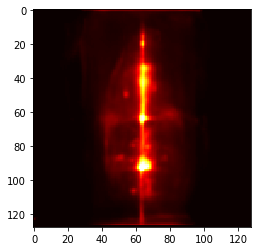

In [8]:
print('C heatmaps summed')
ret = detector.run(image_names[0])
output = ret['output']
pred_obj = output['objns']
img_gt2 = pred_obj.detach().cpu().numpy()
img_r = img_gt2[0,0,:,:]
print(pred_obj.size())
print(pred_obj.max())
plt.imshow(img_r, cmap='hot', interpolation='nearest')

In [ ]:
torch.max(pred_obj)

In [ ]:
descriptores.keys()

In [9]:
from torch.nn.functional import normalize

In [19]:
def cosdis(x,y):
    x = x.unsqueeze(0)
    y = y.unsqueeze(1)
    x_n = normalize(x,dim=1)
    y_n = normalize(y,dim=0)
    return x_n@y_n

In [20]:
D = []
D.append(descriptores['../images/yolo/aceite_0.png'])
D.append(descriptores['../images/yolo/aceite_4.png'])
D.append(descriptores['../images/yolo/cubix_0.png'])
D.append(descriptores['../images/yolo/cubix_5.png'])
D.append(descriptores['../images/yolo/te_0.png'])
D.append(descriptores['../images/yolo/te_8.png'])

In [21]:
matrix = torch.zeros((len(image_names),len(image_names)))
for i in range(len(image_names)):
    for j in range(len(image_names)):
        score = cosdis(D[i],D[j])[0,0]
        matrix[i,j]=score  
    

In [22]:
matrix

tensor([[1.0000, 0.7123, 0.6338, 0.6081, 0.6203, 0.7259],
        [0.7123, 1.0000, 0.6726, 0.6441, 0.6701, 0.7740],
        [0.6338, 0.6726, 1.0000, 0.6881, 0.8588, 0.7186],
        [0.6081, 0.6441, 0.6881, 1.0000, 0.6014, 0.7129],
        [0.6203, 0.6701, 0.8588, 0.6014, 1.0000, 0.7977],
        [0.7259, 0.7740, 0.7186, 0.7129, 0.7977, 1.0000]])

In [7]:
ret.keys()

dict_keys(['results', 'tot', 'load', 'pre', 'net', 'dec', 'post', 'merge', 'output', 'dets'])

In [8]:

print(output.keys())

dict_keys(['objns', 'hm', 'wh', 'reg', 'descriptor'])


In [26]:
hm = pred_obj.squeeze(0).squeeze(0)
print(torch.max(hm))
print(torch.argmax(hm))

tensor(0.7310, device='cuda:0')
tensor(8241, device='cuda:0')


In [30]:
x = int(8241/128)
print(x)
y = 8241 % 128
print(y)
print(hm[x,y])

64
49
tensor(0.7310, device='cuda:0')


In [32]:
decrp = output['descriptor'].squeeze(0)[:,x,y]
print(decrp.shape)

torch.Size([256])
